# 04: Sampling

### Imported Libraries

In [1]:
import sys
print('Python version: %s' % (sys.version))
from collections import Counter
print('\tCounter imported.')

# data management
print('\nData Management Libraries')
import pandas as pd
print('\tpandas version: %s' % (pd.__version__))
import numpy as np
print('\tnumpy version: %s' % (np.__version__))
import regex as re
print('\tregex version: %s' % (re.__version__))

# visualizing
print('\nVisualization Libraries')
from matplotlib import pyplot as plt
import matplotlib
print('\tmatplotlib version: %s' % (matplotlib.__version__))
import seaborn as sns
print('\tseaborn version: %s' % (sns.__version__))

# modeling
print('\nModeling Libraries')
import imblearn
print('\timblearn version: %s' % imblearn.__version__)
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import sklearn
print('\tsklearn version: %s' % sklearn.__version__)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

Python version: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
	Counter imported.

Data Management Libraries
	pandas version: 1.2.3
	numpy version: 1.19.2
	regex version: 2.5.91

Visualization Libraries
	matplotlib version: 3.3.4
	seaborn version: 0.11.1

Modeling Libraries
	imblearn version: 0.8.0
	sklearn version: 0.24.1


### Update Library Settings

In [2]:
# set random state for reproducibility
random_state = 42

# default numpy settings
np.set_printoptions(edgeitems=3)
np.core.arrayprint._line_width = 80

# update settings
np.set_printoptions(edgeitems=15, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# update pandas settings
pd.options.display.max_columns = 12
pd.set_option('max_colwidth', 100) # sets the max number of columns before truncating with an ellipse
pd.options.display.max_rows = 500
pd.set_option('precision',6)

### Helper Functions

In [3]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy\t= %.2f" % (accuracy_score(y_actual, y_predicted)))
    print("Precision\t= %.2f" % (precision_score(y_actual, y_predicted)))
    print("Recall\t\t= %.2f" % (recall_score(y_actual, y_predicted)))
    print("F1 Score\t= %.2f" % (f1_score(y_actual, y_predicted)))
    pass
    
def plot_feature_correlation_heatmap(df,title,xsize,ysize):
    fig, ax = plt.subplots(1,1,figsize=(xsize,ysize))
    corr=df.corr()
    sns.heatmap(corr,cmap='coolwarm_r',annot_kws={'size':20},ax=ax)
    ax.set_title(title,fontsize=14)
    plt.show()
    
def plot_cmat_prc_roc(clf,X_test,y_test):
    fig, ax = plt.subplots(1,3,figsize=(16,4.5))
    plot_confusion_matrix(clf,X_test,y_test,ax=ax[0],cmap='Greys',colorbar=False) 
    ax[0].set_title('Confusion Matrix')
    plot_roc_curve(clf,X_test,y_test,ax=ax[1])
    ax[1].set_title('ROC Curve')
    plot_precision_recall_curve(clf,X_test,y_test,ax=ax[2])
    ax[2].set_title('Precision-Recall Curve')
    plt.show()

### Import Dataframe

In [4]:
df = pd.read_csv('../data/creditcard_03_scaled.csv')

In [5]:
df.head()

,Time_DayAwareMinMax,Amount_MinMax,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
0,-50.000000,0.291190,-1.359807,-0.072781,2.536347,1.378155,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-50.000000,0.005235,1.191857,0.266151,0.166480,0.448154,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-49.998843,0.736946,-1.358354,-1.340163,1.773209,0.379780,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-49.998843,0.240355,-0.966272,-0.185226,1.792993,-0.863291,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-49.997685,0.136214,-1.158233,0.877737,1.548718,0.403034,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [6]:
df.describe()

,Time_DayAwareMinMax,Amount_MinMax,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
count,284798.000000,284798.000000,284798.000000,284798.000000,284798.000000,284798.000000,...,284798.000000,284798.000000,284798.000000,284798.000000,284798.000000,284798.000000
mean,10.575932,0.171444,0.000864,0.000838,0.000469,-0.000270,...,0.000003,0.000015,0.000009,-0.000042,-0.000098,0.001728
std,24.363159,0.466602,1.950921,1.633246,1.512167,1.414448,...,0.605549,0.520703,0.482143,0.398794,0.322507,0.041528
min,-50.000000,0.000000,-46.855047,-48.060856,-33.680984,-5.683171,...,-2.836627,-10.295397,-2.241620,-22.565679,-11.710896,0.000000
25%,-5.840413,0.010879,-0.920274,-0.598518,-0.890206,-0.848663,...,-0.354564,-0.317129,-0.326979,-0.070835,-0.052961,0.000000
50%,12.546008,0.042816,0.018171,0.065496,0.179861,-0.019941,...,0.040977,0.016602,-0.052126,0.001344,0.011243,0.000000
75%,30.542374,0.150149,1.315649,0.803713,1.027214,0.743313,...,0.439524,0.350715,0.240961,0.091046,0.078276,0.000000
max,50.000000,25.127184,2.454930,22.057729,9.382558,13.143668,...,4.022866,7.519589,3.517346,12.152401,22.620072,1.000000


### Prep dataset for model input

In [7]:
X = df.drop('Class', axis=1)     # drop the output series from the dataset to isolate inputs (independent features)
y = df['Class']     # set y to the output series (dependent feature)
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)     # setting training size of dataset to 70%

# Reassemble training independent, dependent features into a 'training' dataframe
df_train = X_train.copy() 
df_train['Class'] = y_train.copy()

In [8]:
len(df_train)

199358

### Setup Classifier for Sampling Review

In [9]:
LogR = LogisticRegression()     # instantiate logistic regression class object

# set grid parameters
grid = {
     'C' : 10.0**np.arange(-2,3)
    ,'penalty' : ['l1', 'l2']     # hyperparameter tuning; regularization parameters
}

# Cross Validation
cv = KFold(         
    n_splits=5
    ,random_state=random_state
    ,shuffle=True
)

clf = GridSearchCV(LogR,grid,cv=cv,n_jobs=-1,scoring='accuracy')

### Fit, Predict Prior to Resampling

In [10]:
clf.fit(X_train,y_train)

C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan 0.999 nan 0.999 nan 0.999 nan 0.999 nan 0.999]
  warnings.warn(
C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.1, 1, 10, 100]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')


[[85268    10]
 [   63    99]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85278
           1       0.91      0.61      0.73       162

    accuracy                           1.00     85440
   macro avg       0.95      0.81      0.87     85440
weighted avg       1.00      1.00      1.00     85440




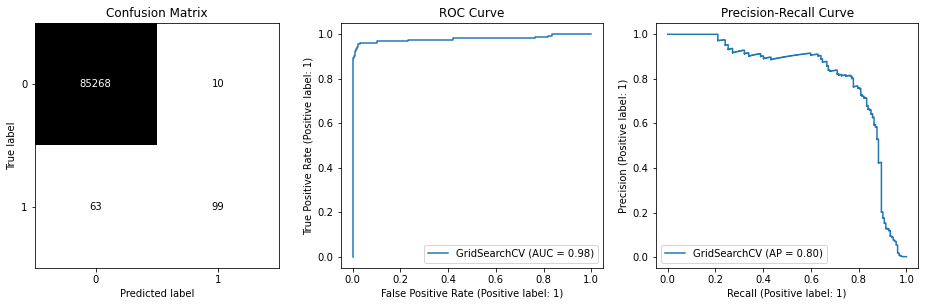

Accuracy	= 1.00
Precision	= 0.91
Recall		= 0.61
F1 Score	= 0.73



In [11]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

### Feature Coorelations

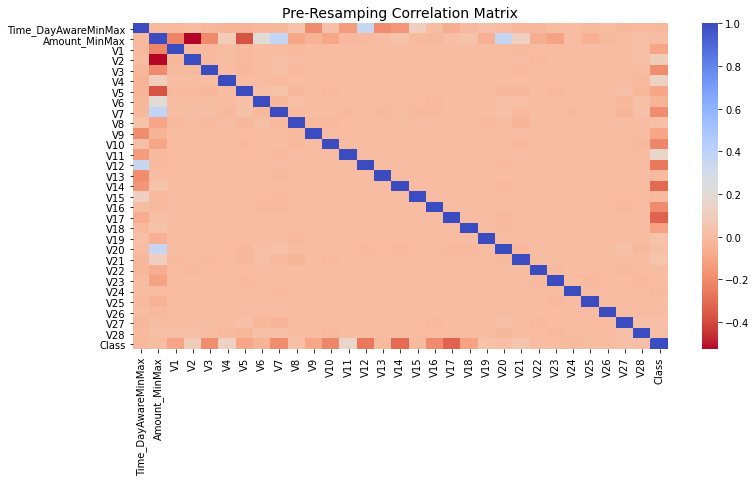

In [12]:
plot_feature_correlation_heatmap(df,'Pre-Resamping Correlation Matrix',12,6)

### Resample with Undersample

330


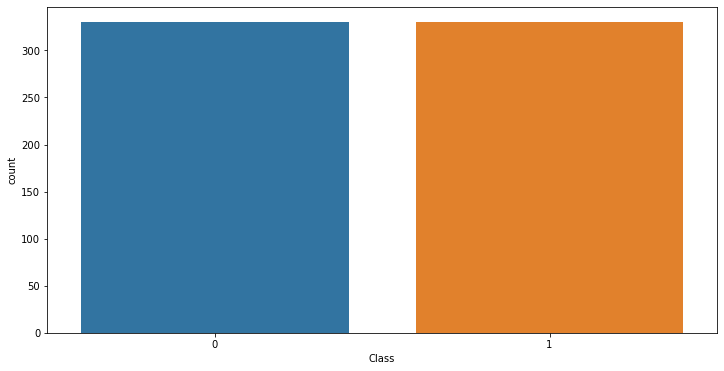

In [13]:
minority_count = len(df_train.Class[df_train.Class == 1]) # get count of minority class
majority_index = df_train.Class[df_train.Class == 0].index # set the majority class index
minority_index = df_train.Class[df_train.Class == 1].index # set the minority class index
undersample_majority_index = np.random.choice(majority_index, minority_count, replace=False) # randomly sample from the majority index to match the minority count without replacement
print(len(undersample_majority_index))

undersample_index = np.concatenate([minority_index,undersample_majority_index]) # concat the new undersampled majority index to the minority index
df_us = df_train.loc[undersample_index] # collect records based on index from the dataframe to assemble an undersampled dataframe

fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=df_us.Class, data=df_us) # plot a count of the class sizes
plt.show()

In [14]:
df_us.describe()

,Time_DayAwareMinMax,Amount_MinMax,V1,V2,V3,V4,...,V24,V25,V26,V27,V28,Class
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,...,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,6.543016,0.223064,-2.256324,1.727708,-3.252280,2.234563,...,-0.037468,0.023728,0.028339,0.110212,0.041238,0.500000
std,26.214887,0.445161,5.303519,3.557476,5.974201,3.123586,...,0.549419,0.678310,0.489847,0.987446,0.420610,0.500379
min,-49.952545,0.000000,-29.876366,-8.402154,-30.558697,-4.022658,...,-2.028024,-4.781606,-1.232233,-7.263482,-1.796363,0.000000
25%,-10.103243,0.003450,-2.890518,-0.308989,-5.041248,-0.127599,...,-0.384973,-0.319083,-0.289818,-0.062062,-0.059835,0.000000
50%,8.762356,0.047040,-0.703564,0.908544,-1.094267,1.326969,...,0.010121,0.044060,-0.013409,0.050627,0.036897,0.500000
75%,28.213905,0.211936,0.949687,2.721612,0.322738,4.138979,...,0.388359,0.392363,0.333616,0.455687,0.199167,1.000000
max,49.974536,4.137357,2.276746,19.167239,3.067529,12.114672,...,1.091435,2.156042,2.745261,3.052358,1.779364,1.000000


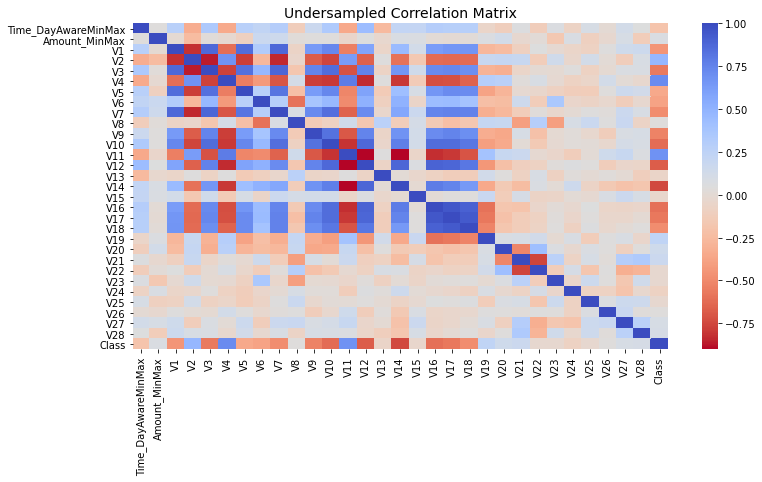

In [15]:
plot_feature_correlation_heatmap(df_us,'Undersampled Correlation Matrix',12,6)

### Train, Score Undersample Model

In [16]:
usX_train = df_us.drop('Class', axis=1)     # drop the output series from the dataset to isolate inputs (independent features)
usy_train = df_us['Class']     # set y to the output series (dependent feature)
clf.fit(usX_train,usy_train)

C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan 0.933 nan 0.935 nan 0.93 nan 0.936 nan 0.932]
  warnings.warn(
C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.1, 1, 10, 100]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')


[[81207  4071]
 [    7   155]]

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     85278
           1       0.04      0.96      0.07       162

    accuracy                           0.95     85440
   macro avg       0.52      0.95      0.52     85440
weighted avg       1.00      0.95      0.97     85440




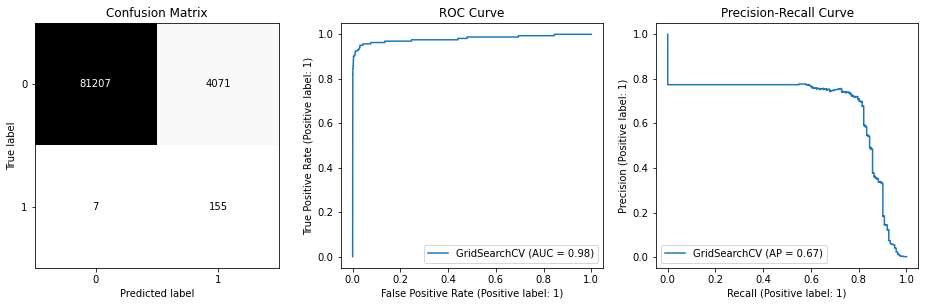

Accuracy	= 0.95
Precision	= 0.04
Recall		= 0.96
F1 Score	= 0.07



In [17]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

# Oversampling

In [18]:
ros = RandomOverSampler(random_state=random_state) # instantiate the oversampler
osX_train,osy_train = ros.fit_resample(X_train,y_train) # resample the dataset
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(osy_train))

Before fit: Counter({0: 199028, 1: 330})
After fit: Counter({0: 199028, 1: 199028})


In [19]:
df_os = osX_train.copy()
df_os['Class'] = osy_train.copy() # just making this for the heatmap

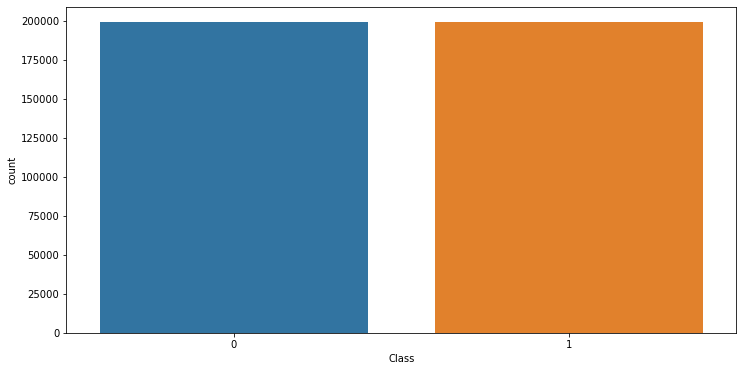

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=df_os.Class, data=df_os) # plot a count of the class sizes
plt.show()

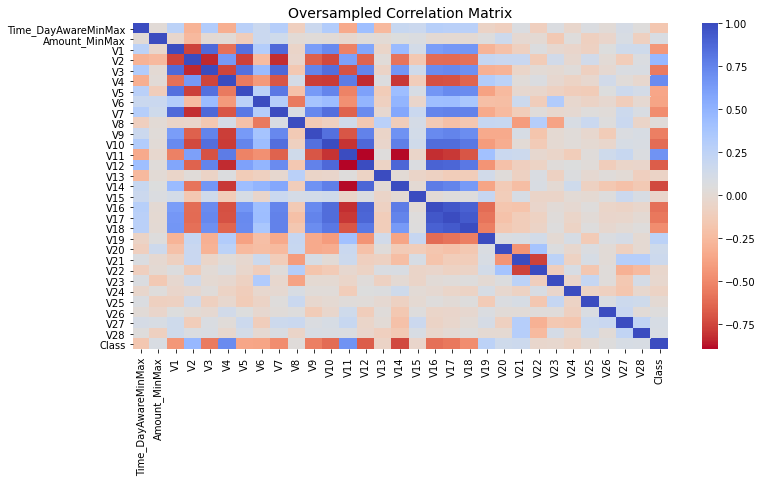

In [21]:
plot_feature_correlation_heatmap(df_os,'Oversampled Correlation Matrix',12,6)

In [22]:
clf.fit(osX_train,osy_train)

C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan 0.942 nan 0.942 nan 0.942 nan 0.942 nan 0.941]
  warnings.warn(
C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.1, 1, 10, 100]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')


[[82775  2503]
 [    7   155]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85278
           1       0.06      0.96      0.11       162

    accuracy                           0.97     85440
   macro avg       0.53      0.96      0.55     85440
weighted avg       1.00      0.97      0.98     85440




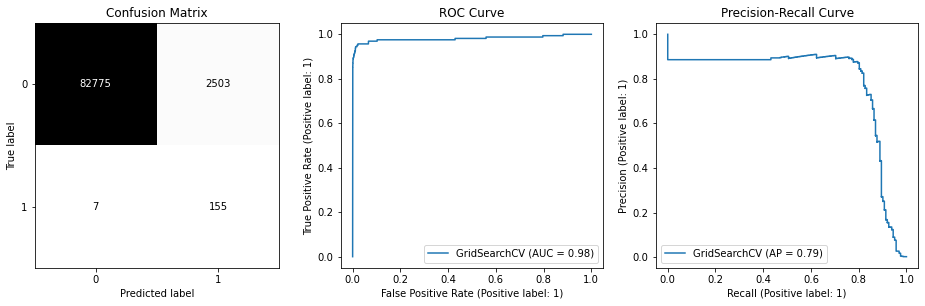

Accuracy	= 0.97
Precision	= 0.06
Recall		= 0.96
F1 Score	= 0.11



In [23]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

# Oversampling with Smote

In [24]:
sm = SMOTE(random_state=random_state)
smX_train,smy_train = sm.fit_resample(X_train,y_train)
print('Before fit: %s' % Counter(y_train))
print('After fit: %s' % Counter(smy_train))

Before fit: Counter({0: 199028, 1: 330})
After fit: Counter({0: 199028, 1: 199028})


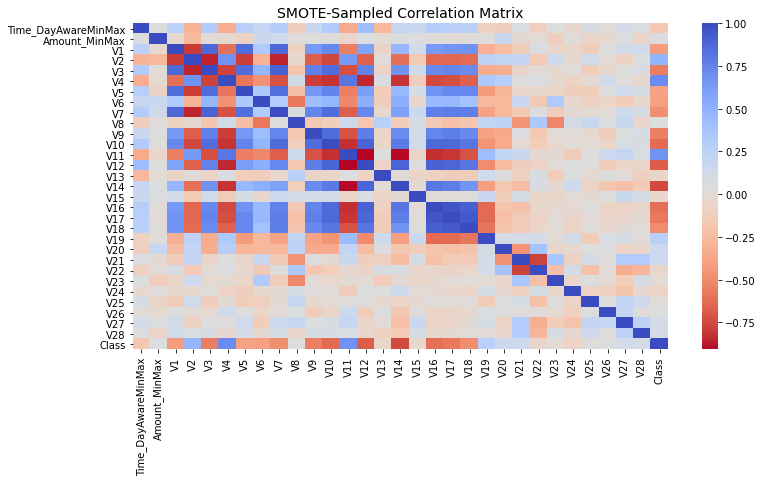

In [25]:
smote_df = smX_train.copy()
smote_df['Class'] = smy_train.copy()
plot_feature_correlation_heatmap(smote_df,'SMOTE-Sampled Correlation Matrix',12,6)

In [26]:
clf.fit(smX_train,smy_train)

C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan 0.94 nan 0.941 nan 0.941 nan 0.941 nan 0.941]
  warnings.warn(
C:\Users\bushjam\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.1, 1, 10, 100]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')


[[82527  2751]
 [    8   154]]

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85278
           1       0.05      0.95      0.10       162

    accuracy                           0.97     85440
   macro avg       0.53      0.96      0.54     85440
weighted avg       1.00      0.97      0.98     85440




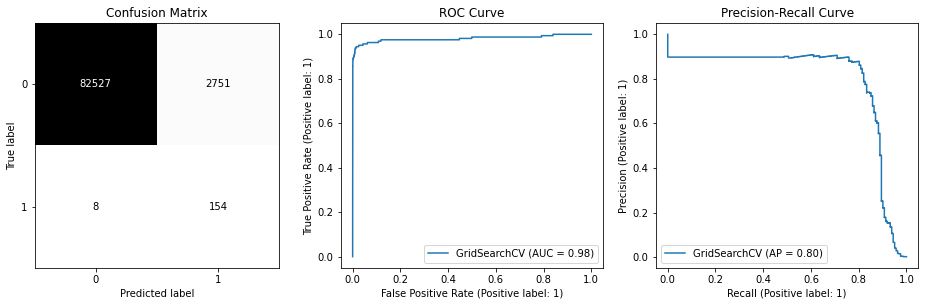

Accuracy	= 0.97
Precision	= 0.05
Recall		= 0.95
F1 Score	= 0.10



In [27]:
y_pred = clf.predict(X_test) # predict on test

# evaluation outputs
print()
print(confusion_matrix(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))
print()
plot_cmat_prc_roc(clf,X_test,y_test)
generate_model_report(y_test,y_pred)
print()

### Negative Correlations

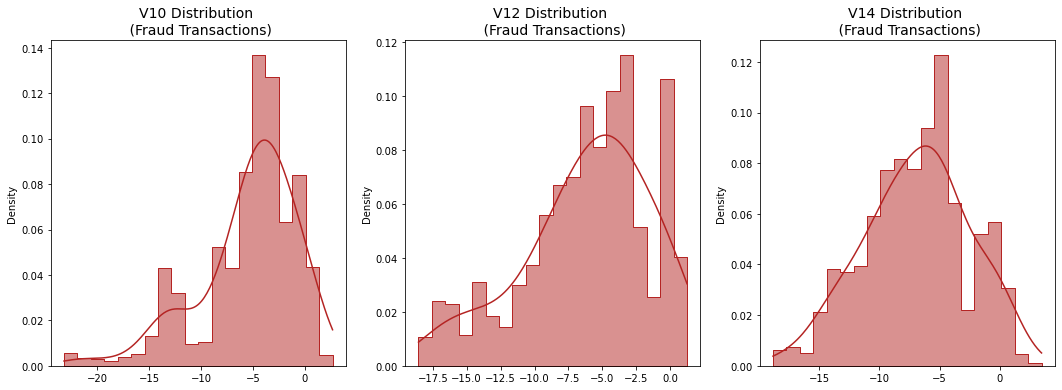

In [28]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))

v10_fraud_dist = smote_df['V10'].loc[smote_df['Class'] == 1].values
sns.histplot(v10_fraud_dist,ax=ax1,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax1.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = smote_df['V12'].loc[smote_df['Class'] == 1].values
sns.histplot(v12_fraud_dist,ax=ax2,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = smote_df['V14'].loc[smote_df['Class'] == 1].values
sns.histplot(v14_fraud_dist,ax=ax3,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### Negative Correlations

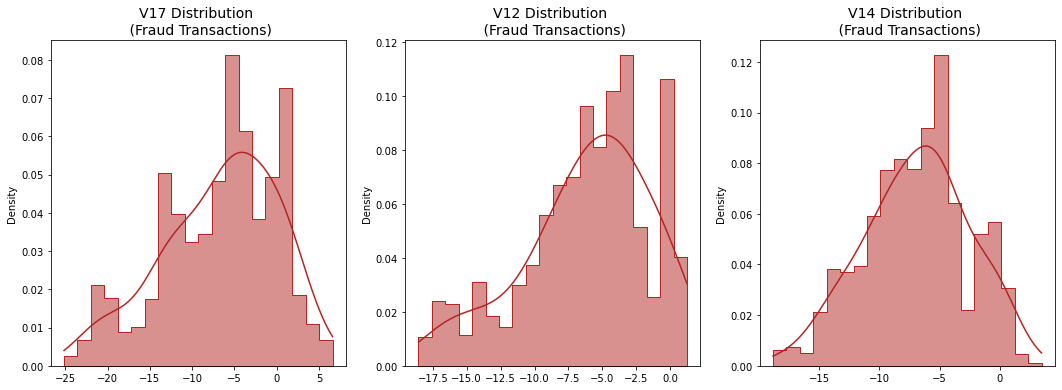

In [29]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))

v17_fraud_dist = smote_df['V17'].loc[smote_df['Class'] == 1].values
sns.histplot(v17_fraud_dist,ax=ax1,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax1.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = smote_df['V12'].loc[smote_df['Class'] == 1].values
sns.histplot(v12_fraud_dist,ax=ax2,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_fraud_dist = smote_df['V14'].loc[smote_df['Class'] == 1].values
sns.histplot(v14_fraud_dist,ax=ax3,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#b42423')
ax3.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### Positive Coorelations

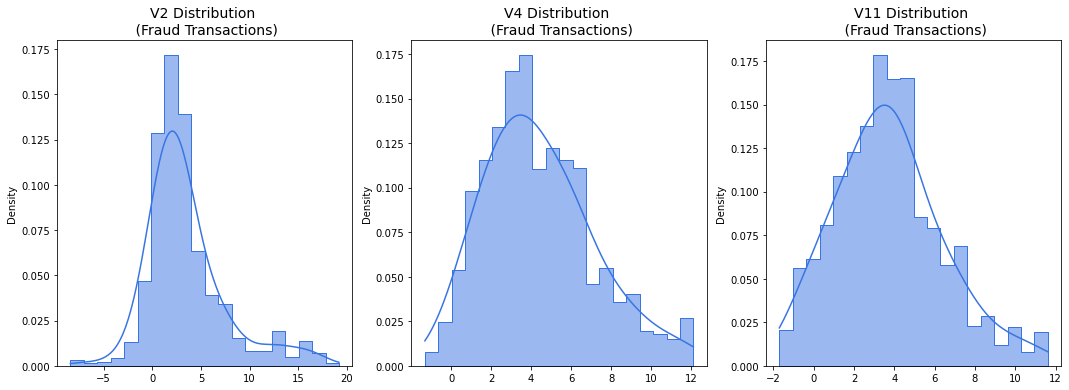

In [30]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))

v2_fraud_dist = smote_df['V2'].loc[smote_df['Class'] == 1].values
sns.histplot(v2_fraud_dist,ax=ax1,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#3875e3')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v4_fraud_dist = smote_df['V4'].loc[smote_df['Class'] == 1].values
sns.histplot(v4_fraud_dist,ax=ax2,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#3875e3')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v11_fraud_dist = smote_df['V11'].loc[smote_df['Class'] == 1].values
sns.histplot(v11_fraud_dist,ax=ax3,stat='density',bins=20,common_norm=False,element="step",kde=True,kde_kws={'bw_adjust':5},color='#3875e3')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### Output Adjusted Dataframe

In [31]:
df.to_csv('../data/creditcard_04.csv',index=False)